# Project 5 - Vehicle Detection and Tracking

## Initial Imports

In [1]:
#Initial Imports
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import tree
from scipy.ndimage.measurements import label
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


## Functions / All the things

In [ ]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# For Use:
# Add bounding boxes in this format, these are just example coordinates.
# bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
#           ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

# result = draw_boxes(image, bboxes)
# plt.imshow(result)

##################

# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
        
    return bbox_list
#for use
# bboxes = find_matches(image, templist)
# result = draw_boxes(image, bboxes)
# plt.imshow(result)
##############################################

# Define a function to compute color histogram features  
def color_hist(img, nbins=64, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

# Define a function to compute hsv histogram features  
def hsv_hist(img, nbins=64, bins_range=(0, 256)):
    # Compute the histogram of the hsv channels separately
    hhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    shist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    vhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hhist[0], shist[0], vhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hhist, shist, vhist, bin_centers, hist_features

# Define a function to compute yuv histogram features  
def yuv_hist(img, nbins=64, bins_range=(0, 256)):
    # Compute the histogram of the hsv channels separately
    yhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    uhist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    vhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = yhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((yhist[0], uhist[0], vhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return yhist, uhist, vhist, bin_centers, hist_features

# rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# # Plot a figure with all three bar charts
# if rh is not None:
#     fig = plt.figure(figsize=(12,3))
#     plt.subplot(131)
#     plt.bar(bincen, rh[0])
#     plt.xlim(0, 256)
#     plt.title('R Histogram')
#     plt.subplot(132)
#     plt.bar(bincen, gh[0])
#     plt.xlim(0, 256)
#     plt.title('G Histogram')
#     plt.subplot(133)
#     plt.bar(bincen, bh[0])
#     plt.xlim(0, 256)
#     plt.title('B Histogram')
#     fig.tight_layout()
# else:
#     print('Your function is returning None for at least one variable...')
    
#############################

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

#For Use:
# # Read a color image
# img = cv2.imread("000275.png")

# # Select a small fraction of pixels to plot by subsampling it
# scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
# img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# # Convert subsampled image to desired color space(s)
# img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
# img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
# img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# # Plot and show
# plot3d(img_small_RGB, img_small_rgb)
# plt.show()

# plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
# plt.show()

#############################################

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(64, 64)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

#For Use:
#feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))
# Plot features
# plt.plot(feature_vec)
# plt.title('Spatially Binned Features')

###############################################

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

#For Use:
# print('Your function returned a count of', 
#       data_info["n_cars"], ' cars and', 
#       data_info["n_notcars"], ' non-cars')
# print('of size: ',data_info["image_shape"], ' and data type:', 
#       data_info["data_type"])
# # Just for fun choose random car / not-car indices and plot example images   
# car_ind = np.random.randint(0, len(cars))
# notcar_ind = np.random.randint(0, len(notcars))
# Read in car / not-car images
# car_image = mpimg.imread(cars[car_ind])
# notcar_image = mpimg.imread(notcars[notcar_ind])


# # Plot the examples
# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(car_image)
# plt.title('Example Car Image')
# plt.subplot(122)
# plt.imshow(notcar_image)
# plt.title('Example Not-car Image')
#########################

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# #For Use:
# # Generate a random index to look at a car image
# ind = np.random.randint(0, len(cars))
# # Read in the image
# image = mpimg.imread(cars[ind])
# gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# # Define HOG parameters
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# # Call our function with vis=True to see an image output
# features, hog_image = get_hog_features(gray, orient, 
#                         pix_per_cell, cell_per_block, 
#                         vis=True, feature_vec=False)


# # Plot the examples
# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(image, cmap='gray')
# plt.title('Example Car Image')
# plt.subplot(122)
# plt.imshow(hog_image, cmap='gray')
# plt.title('HOG Visualization')
#################################################

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(64, 64),
                        hist_bins=64, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file) #mpimg.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#For Use:
# images = glob.glob('*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)
        
# car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))
# notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))

# if len(car_features) > 0:
#     # Create an array stack of feature vectors
#     X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
#     # Fit a per-column scaler
#     X_scaler = StandardScaler().fit(X)
#     # Apply the scaler to X
#     scaled_X = X_scaler.transform(X)
#     car_ind = np.random.randint(0, len(cars))
#     # Plot an example of raw and scaled features
#     fig = plt.figure(figsize=(12,4))
#     plt.subplot(131)
#     plt.imshow(mpimg.imread(cars[car_ind]))
#     plt.title('Original Image')
#     plt.subplot(132)
#     plt.plot(X[car_ind])
#     plt.title('Raw Features')
#     plt.subplot(133)
#     plt.plot(scaled_X[car_ind])
#     plt.title('Normalized Features')
#     fig.tight_layout()
# else: 
#     print('Your function only returns empty feature vectors...')
##########################################################

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

#####################################################

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(64,64),
                        hist_bins=64, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

#####################################

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(64, 64), hist_bins=64, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

#######################################

def add_heat(heatmap, box_list):
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    #make a copy of the image
    draw_img = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((int(np.min(nonzerox)), int(np.min(nonzeroy))), (int(np.max(nonzerox)), int(np.max(nonzeroy))))
        # Draw the box on the image
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return draw_img

######################




## Implementation

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


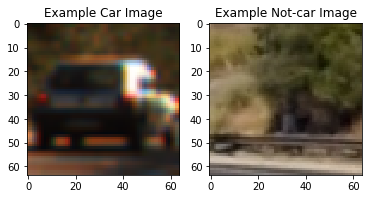

In [3]:
#read the images for cars/not cars
car_images = glob.glob('vehicles/*/*.png')
noncar_images = glob.glob('non-vehicles/*/*.png')
cars = []
notcars = []
for image in noncar_images:
    notcars.append(image)
for image in car_images:
    cars.append(image)

data_info = data_look(car_images,noncar_images)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
#Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Explore Color Spaces of the Images

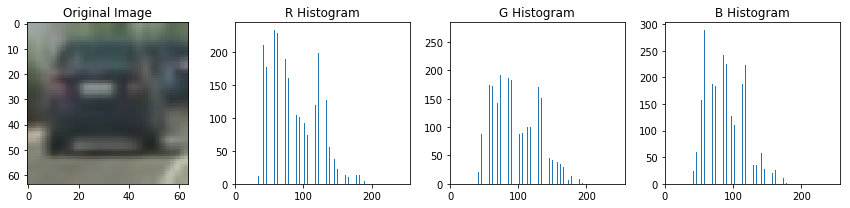

In [4]:
car_image = cv2.imread(cars[0]) #Be sure to use cv2.imread and scale to 0 -255 NOT mpimg.imread(cars[0])
#scale by changing color spaces
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(car_image, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(car_image)
    plt.title('Original Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

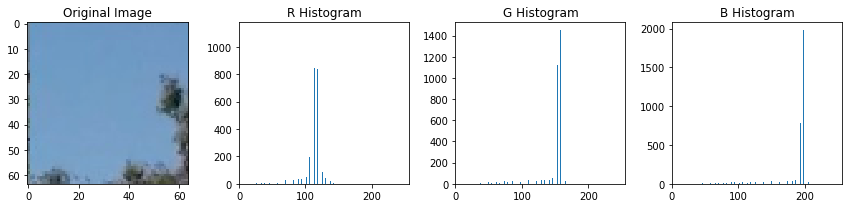

In [5]:
noncar_image = cv2.imread(notcars[0]) #Be sure to use cv2.imread and scale to 0 -255 NOT mpimg.imread(cars[0])
#scale by changing color spaces
noncar_image = cv2.cvtColor(noncar_image, cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(noncar_image, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(noncar_image)
    plt.title('Original Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

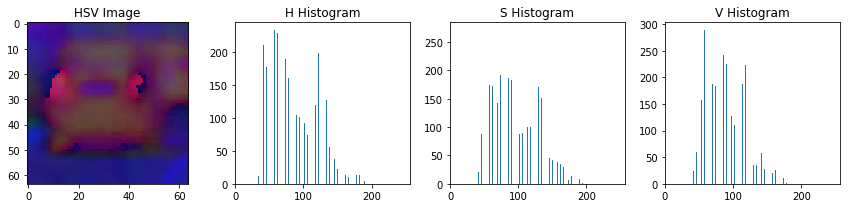

In [6]:
img_copy = np.copy(car_image)
car_image_hsv = cv2.cvtColor(img_copy, cv2.COLOR_RGB2HSV)
rh, gh, bh, bincen, feature_vec = color_hist(car_image, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(car_image_hsv)
    plt.title('HSV Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('H Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('S Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

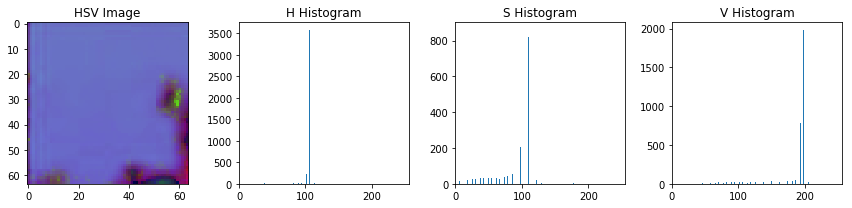

In [7]:
img_copy2 = np.copy(noncar_image)
noncar_image_hsv = cv2.cvtColor(img_copy2, cv2.COLOR_RGB2HSV)
rh, gh, bh, bincen, feature_vec = color_hist(noncar_image_hsv, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(noncar_image_hsv)
    plt.title('HSV Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('H Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('S Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

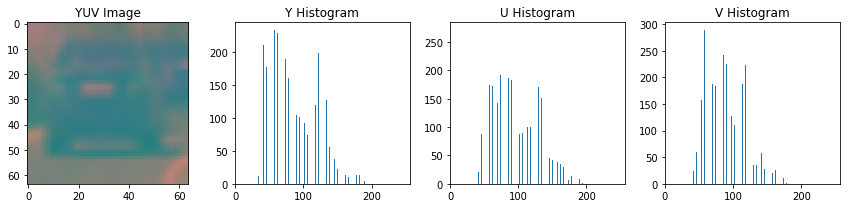

In [8]:
img_copy3 = np.copy(car_image)
car_image_YUV = cv2.cvtColor(img_copy3, cv2.COLOR_RGB2YUV)
rh, gh, bh, bincen, feature_vec = color_hist(car_image, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(car_image_YUV)
    plt.title('YUV Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('U Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

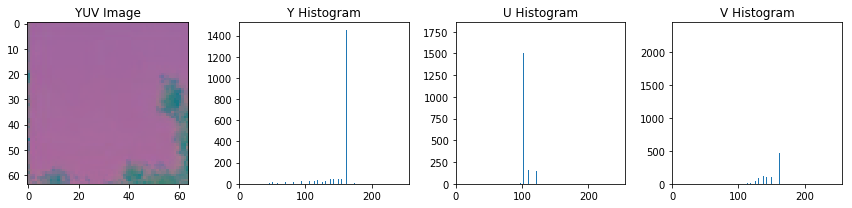

In [9]:
img_copy4 = np.copy(noncar_image)
noncar_image_yuv = cv2.cvtColor(img_copy2, cv2.COLOR_RGB2YUV)
rh, gh, bh, bincen, feature_vec = color_hist(noncar_image_yuv, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(noncar_image_yuv)
    plt.title('YUV Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('U Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

## Look at Spatial Bins

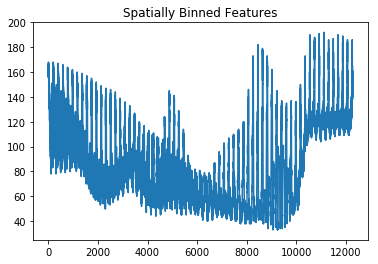

In [10]:
feature_vec = bin_spatial(car_image, color_space='RGB', size=(64, 64))
#Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

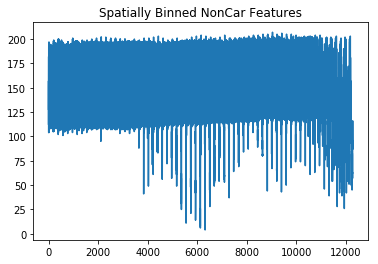

In [11]:
feature_vec = bin_spatial(noncar_image, color_space='RGB', size=(64, 64))
#Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned NonCar Features')

## Look at HOG Features

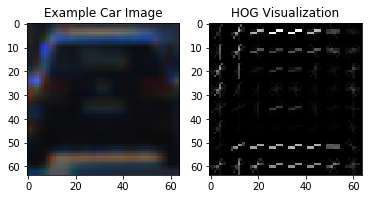

In [12]:
# # Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image
example_car = cv2.imread(car_images[ind])
example_car = cv2.cvtColor(example_car, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(example_car, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(example_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

(720, 1280, 3)


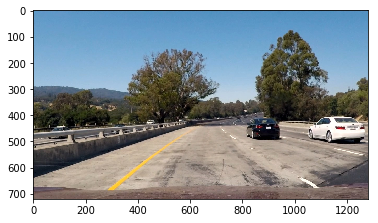

In [13]:
### Tweak these parameters and see how the results change.
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
example_img = cv2.imread('test1.jpg')
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
print(example_img.shape)
plt.imshow(example_img)
y_start_stop = [example_img.shape[0]*.5, example_img.shape[0]*.9] # Min and max in y to search in slide_window()

In [14]:
#extract the features for cars/ noncars
car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [15]:
#Define the features and labels vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [16]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


In [17]:
#Fit the classifier and make a prediction
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 12 orientations 16 pixels per cell and 4 cells per block
Feature vector length: 13056
22.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9842


In [18]:
#Use a decision tree classifier
#Fit the classifier and make a prediction
# Use a decision tree 
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)
# Check the training time for the Decision tree
t=time.time()
tree_clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train Decision Tree...')
# Check the score of the tree
print('Test Accuracy of Decision Tree = ', round(tree_clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

243.85 Seconds to train Decision Tree...
Test Accuracy of Decision Tree =  0.9662


Number of windows: 127


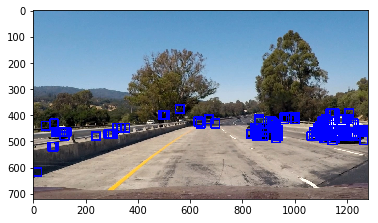

In [53]:
image = mpimg.imread('test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
y_start_stop[0] = int(y_start_stop[0])

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(32,32), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
print('Number of windows: %d' % len(hot_windows))
plt.imshow(window_img)

(720, 1280)
6 cars found


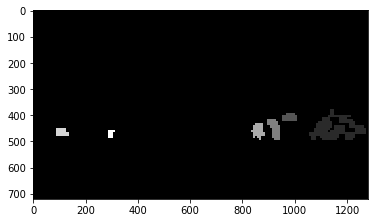

In [72]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
print(heat.shape)
#1 frame
heat = add_heat(heat,hot_windows)
# 2 frame
heat = add_heat(heat, hot_windows)
# 3 frame
heat = add_heat(heat, hot_windows)
#4 frame
heat = add_heat(heat, hot_windows)
#5 frame
heat = add_heat(heat, hot_windows)
heat = apply_threshold(heat, 10)
labels = label(heat)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

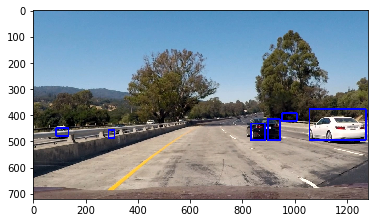

In [55]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)

In [83]:
#define a new heatmap for the video
ex_image = cv2.imread('ex_vid_img.jpg')
heat2 = np.zeros_like(ex_image[:,:,0]).astype(np.float)
total = 0
print(heat2.shape)

(540, 960)


In [84]:

def processImage(img):
    draw_image = np.copy(img)
    #print(img.shape)
    global heat2
    #print(heat2.shape)
    global total
    global svc
    global X_scaler
    color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 4 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (64, 64) # Spatial binning dimensions
    hist_bins = 64    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [int(img.shape[0]*.4), int(img.shape[0]*.9)]
   
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(32, 32), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    #window_img = draw_boxes(draw_image, hot_windows, color=(125, 125, 255), thick=2)
    #define a new heatmap for the video
    heat2 = add_heat(heat2,hot_windows) #add more heat to the original heatmap
    heat2 = add_heat(heat2,hot_windows) #add more heat to the original heatmap
    heat2 = add_heat(heat2,hot_windows) #add more heat to the original heatmap
    heat2 = add_heat(heat2,hot_windows) #add more heat to the original heatmap
    apply_threshold(heat2, .2)
    labels = label(heat2)
    print(labels[1], 'cars found')
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(draw_image, labels)
    total+=1
    return draw_img

In [ ]:
#test on video
video_output = 'test_project_video_output.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")

output_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time output_clip.write_videofile(video_output, audio=False)

0 cars found
[MoviePy] >>>> Building video test_project_video_output.mp4
[MoviePy] Writing video test_project_video_output.mp4

















  0%|          | 0/222 [00:00<?, ?it/s]














  0%|          | 1/222 [00:08<30:18,  8.23s/it]

0 cars found


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))